In [55]:
import ast
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score
from wafer_dataset import WaferDataset, parse_failure_type_field
import os, time

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from wafer_dataset import WaferDataset, parse_failure_type_field
# ---------------------------

In [60]:
df2 = pd.read_pickle('wb_withlabel.pkl')
df2.head(1)

,index,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0


In [61]:
len(df2)

172950

In [62]:
df2['failureType'].value_counts()

[[none]]         147431
[[Edge-Ring]]      9680
[[Edge-Loc]]       5189
[[Center]]         4294
[[Loc]]            3593
[[Scratch]]        1193
[[Random]]          866
[[Donut]]           555
[[Near-full]]       149
Name: failureType, dtype: int64

In [111]:
# ============================================
# 오토인코더 기반 이상 탐지 설정
# ============================================
IMG_SIZE = 56  # TS_model과 동일한 입력 크기
BATCH_SIZE = 96
SEED = 1414

# 재현성 설정
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 정상 데이터 (none)와 비정상 데이터 분리
normal_df = df2[df2['failureNum'] == 8].copy()  # 정상 데이터
anomaly_df = df2[df2['failureNum'] != 8].copy()  # 비정상 데이터

print(f"\n정상 데이터 (none): {len(normal_df)}개")
print(f"비정상 데이터 (패턴): {len(anomaly_df)}개")
print(f"\n비정상 데이터 분포:")
print(anomaly_df['failureNum'].value_counts().sort_index())


Using device: cuda

정상 데이터 (none): 147431개
비정상 데이터 (패턴): 25519개

비정상 데이터 분포:
0    4294
1     555
2    5189
3    9680
4    3593
5     866
6    1193
7     149
Name: failureNum, dtype: int64


In [65]:
# TS_model과 동일한 전처리 방식
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# 정상 데이터를 train/val로 분할 (오토인코더 학습용)
normal_train_df, normal_val_df = train_test_split(
    normal_df,
    test_size=0.2,
    random_state=SEED,
)

# 데이터셋 및 데이터로더 생성
normal_train_dataset = WaferDataset(normal_train_df, transform=train_transform)
normal_val_dataset = WaferDataset(normal_val_df, transform=val_transform)
anomaly_dataset = WaferDataset(anomaly_df, transform=val_transform)  # 비정상 데이터는 검증용

normal_train_loader = DataLoader(normal_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
normal_val_loader = DataLoader(normal_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
anomaly_loader = DataLoader(anomaly_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"정상 학습 데이터: {len(normal_train_dataset)}개")
print(f"정상 검증 데이터: {len(normal_val_dataset)}개")
print(f"비정상 테스트 데이터: {len(anomaly_dataset)}개")


정상 학습 데이터: 117944개
정상 검증 데이터: 29487개
비정상 테스트 데이터: 25519개


In [66]:
# 오토인코더 모델 정의 (균형잡힌 인코더-디코더 구조)
class WaferAutoEncoder(nn.Module):
    def __init__(self):
        super(WaferAutoEncoder, self).__init__()
        
        # Encoder (TS_model의 TeacherNet 스타일, 대칭 구조)
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 56 -> 28
            
            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28 -> 14
            
            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14 -> 7
        )
        
        # Decoder (인코더와 대칭 구조)
        self.decoder = nn.Sequential(
            # Block 1
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2, padding=0),  # 7 -> 14
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),  # 추가 Conv로 대칭성 확보
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Block 2
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=0),  # 14 -> 28
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),  # 추가 Conv로 대칭성 확보
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Block 3
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2, padding=0),  # 28 -> 56
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        """인코더만 사용 (특징 추출용)"""
        return self.encoder(x)


In [67]:


# 모델 초기화
ae_model = WaferAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(ae_model.parameters(), lr=1e-3, weight_decay=1e-4)

print(ae_model)
print(f"\n모델 파라미터 수: {sum(p.numel() for p in ae_model.parameters()):,}")


WaferAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(6

In [115]:
summary(ae_model,(1,56,56), batch_size=96)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [96, 32, 56, 56]             320
       BatchNorm2d-2           [96, 32, 56, 56]              64
              ReLU-3           [96, 32, 56, 56]               0
            Conv2d-4           [96, 32, 56, 56]           9,248
       BatchNorm2d-5           [96, 32, 56, 56]              64
              ReLU-6           [96, 32, 56, 56]               0
         MaxPool2d-7           [96, 32, 28, 28]               0
            Conv2d-8           [96, 64, 28, 28]          18,496
       BatchNorm2d-9           [96, 64, 28, 28]             128
             ReLU-10           [96, 64, 28, 28]               0
           Conv2d-11           [96, 64, 28, 28]          36,928
      BatchNorm2d-12           [96, 64, 28, 28]             128
             ReLU-13           [96, 64, 28, 28]               0
        MaxPool2d-14           [96, 64,

In [68]:
# 오토인코더 학습 (정상 데이터만 사용)
EPOCHS = 40
train_losses = []
val_losses = []

print("=" * 60)
print("오토인코더 학습 시작 (정상 데이터만 사용)")
print("=" * 60)

for epoch in range(1, EPOCHS + 1):
    # Train
    ae_model.train()
    train_loss = 0.0
    train_samples = 0
    
    for xb, _ in tqdm(normal_train_loader, desc=f"Epoch {epoch}/{EPOCHS} [Train]"):
        xb = xb.to(device)
        
        optimizer.zero_grad()
        reconstructed = ae_model(xb)
        loss = criterion(reconstructed, xb)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * xb.size(0)
        train_samples += xb.size(0)
    
    train_loss_avg = train_loss / train_samples
    
    # Validation (정상 데이터)
    ae_model.eval()
    val_loss = 0.0
    val_samples = 0
    
    with torch.no_grad():
        for xb, _ in normal_val_loader:
            xb = xb.to(device)
            reconstructed = ae_model(xb)
            loss = criterion(reconstructed, xb)
            val_loss += loss.item() * xb.size(0)
            val_samples += xb.size(0)
    
    val_loss_avg = val_loss / val_samples
    
    train_losses.append(train_loss_avg)
    val_losses.append(val_loss_avg)
    
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | Train Loss: {train_loss_avg:.6f} | Val Loss: {val_loss_avg:.6f}")

print("\n학습 완료!")


오토인코더 학습 시작 (정상 데이터만 사용)


Epoch 1/40 [Train]: 100%|██████████| 1229/1229 [01:18<00:00, 15.59it/s]


Epoch   1 | Train Loss: 0.009606 | Val Loss: 0.000154


Epoch 5/40 [Train]: 100%|██████████| 1229/1229 [01:16<00:00, 16.08it/s]


Epoch   5 | Train Loss: 0.000003 | Val Loss: 0.000002


Epoch 10/40 [Train]: 100%|██████████| 1229/1229 [01:15<00:00, 16.26it/s]


Epoch  10 | Train Loss: 0.000002 | Val Loss: 0.000001


Epoch 15/40 [Train]: 100%|██████████| 1229/1229 [01:16<00:00, 16.04it/s]


Epoch  15 | Train Loss: 0.000001 | Val Loss: 0.000001


Epoch 20/40 [Train]: 100%|██████████| 1229/1229 [01:12<00:00, 16.85it/s]


Epoch  20 | Train Loss: 0.000001 | Val Loss: 0.000001


Epoch 25/40 [Train]: 100%|██████████| 1229/1229 [01:16<00:00, 16.02it/s]


Epoch  25 | Train Loss: 0.000001 | Val Loss: 0.000001


Epoch 30/40 [Train]: 100%|██████████| 1229/1229 [01:16<00:00, 16.16it/s]


Epoch  30 | Train Loss: 0.000001 | Val Loss: 0.000001


Epoch 35/40 [Train]: 100%|██████████| 1229/1229 [01:21<00:00, 15.15it/s]


Epoch  35 | Train Loss: 0.000001 | Val Loss: 0.000001


Epoch 40/40 [Train]: 100%|██████████| 1229/1229 [01:22<00:00, 14.84it/s]


Epoch  40 | Train Loss: 0.000001 | Val Loss: 0.000001

학습 완료!


In [ ]:
# 재구성 오차 계산 함수
def calculate_reconstruction_error(model, loader, device):
    """재구성 오차를 계산하고 반환"""
    model.eval()
    errors = []
    labels = []
    
    with torch.no_grad():
        for xb, yb in tqdm(loader, desc="재구성 오차 계산"):
            xb = xb.to(device)
            reconstructed = model(xb)
            
            # MSE 오차 계산 (배치별)
            batch_errors = torch.mean((xb - reconstructed) ** 2, dim=(1, 2, 3))
            errors.extend(batch_errors.cpu().numpy())
            labels.extend(yb.numpy())
    
    return np.array(errors), np.array(labels)

# 정상 데이터와 비정상 데이터의 재구성 오차 계산
print("정상 데이터 재구성 오차 계산 중...")
normal_errors, normal_labels = calculate_reconstruction_error(ae_model, normal_val_loader, device)

print("비정상 데이터 재구성 오차 계산 중...")
anomaly_errors, anomaly_labels = calculate_reconstruction_error(ae_model, anomaly_loader, device)




정상 데이터 재구성 오차 계산 중...


재구성 오차 계산: 100%|██████████| 308/308 [00:16<00:00, 18.45it/s]


비정상 데이터 재구성 오차 계산 중...


재구성 오차 계산: 100%|██████████| 266/266 [00:14<00:00, 17.92it/s]


정상 데이터 평균 재구성 오차: 0.000001 ± 0.000000
비정상 데이터 평균 재구성 오차: 0.000001 ± 0.000001


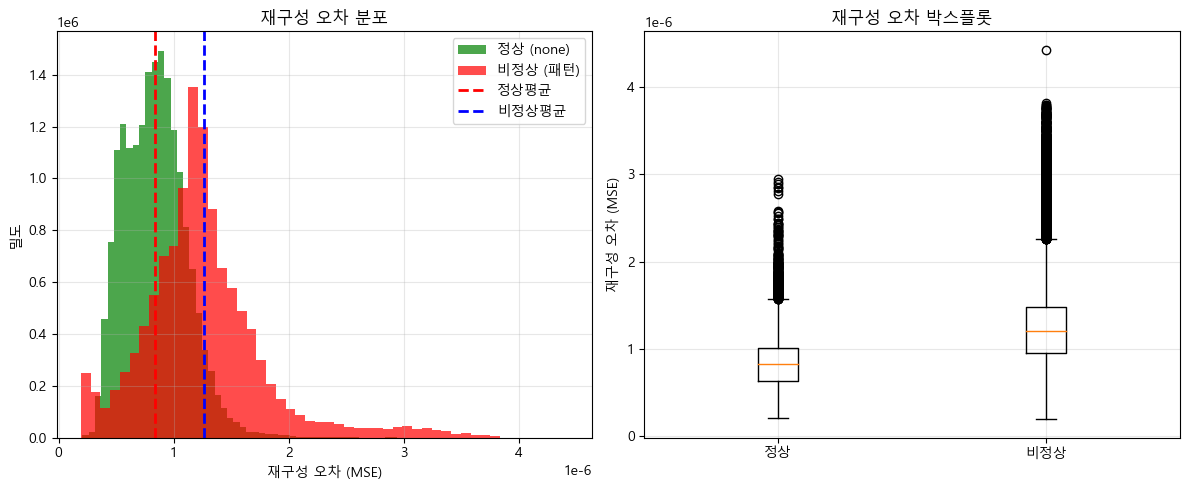

In [107]:
# 재구성 오차 분포 시각화
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

font_path = "C:/Windows/Fonts/malgun.ttf"  # '맑은 고딕' 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

plt.figure(figsize=(12, 5))

mean_error = np.mean(normal_errors)
mean_anerror = np.mean(anomaly_errors)

# 히스토그램
plt.subplot(1, 2, 1)
plt.hist(normal_errors, bins=50, alpha=0.7, label='정상 (none)', color='green', density=True)
plt.hist(anomaly_errors, bins=50, alpha=0.7, label='비정상 (패턴)', color='red', density=True)
plt.axvline(mean_error, color='red', linestyle='--', linewidth=2,label = '정상평균')
plt.axvline(mean_anerror, color='blue', linestyle='--', linewidth=2,label = '비정상평균')


plt.xlabel('재구성 오차 (MSE)')
plt.ylabel('밀도')
plt.title('재구성 오차 분포')
plt.legend()
plt.grid(True, alpha=0.3)

# 박스플롯
plt.subplot(1, 2, 2)
plt.boxplot([normal_errors, anomaly_errors], labels=['정상', '비정상'])
plt.ylabel('재구성 오차 (MSE)')
plt.title('재구성 오차 박스플롯')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


비정상이랑 정상 평균이 다른것을 확인

In [114]:

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, 
    precision_score, recall_score, f1_score, confusion_matrix
)

# 정상/비정상 데이터 준비
all_errors = np.concatenate([normal_errors, anomaly_errors])
all_labels = np.concatenate([
    np.zeros(len(normal_errors)),  # 정상 = 0
    np.ones(len(anomaly_errors))   # 비정상 = 1
])

# ROC 곡선 계산
fpr, tpr, thresholds_roc = roc_curve(all_labels, all_errors)
roc_auc = auc(fpr, tpr)

# Precision-Recall 곡선 계산
precision, recall, thresholds_pr = precision_recall_curve(all_labels, all_errors)
pr_auc = auc(recall, precision)

# ============================================
# 최적 임계값 찾기: PR 곡선 기반 (불균형 데이터에 적합)
# ============================================
# ROC 곡선에서 (0,1) 좌표는 완벽한 분류기를 의미 (FPR=0, TPR=1)
# 이 점에 가장 가까운 임계값을 선택
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
best_dist_idx = np.argmin(distances)
best_threshold = thresholds_roc[best_dist_idx]
best_dist = distances[best_dist_idx]

# 선택된 임계값으로 예측 및 성능 계산
pred_labels = (all_errors >= best_threshold).astype(int)
best_precision = precision_score(all_labels, pred_labels)
best_recall = recall_score(all_labels, pred_labels)
best_f1 = f1_score(all_labels, pred_labels)
cm = confusion_matrix(all_labels, pred_labels)

# ============================================
# 결과 출력
# ============================================
print("\n" + "="*70)
print("📊 이상 탐지 성능 평가 결과")
print("="*70)

print(f"\n📈 전체 성능 지표")
print(f"   PR AUC:  {pr_auc:.4f} ")
print(f"   ROC AUC: {roc_auc:.4f} ")

print(f"\n✨ 선택된 임계값에서의 성능")
print(f"   Precision: {best_precision:.4f}  (예측한 비정상 중 실제 비정상 비율)")
print(f"   Recall:    {best_recall:.4f}    (실제 비정상 중 탐지한 비율)")
print(f"   F1 Score:  {best_f1:.4f}        (Precision과 Recall의 조화평균)")

print(f"\n📋 혼동 행렬 (임계값 = {best_threshold:.6f})")
print("   " + " "*20 + "예측")
print("   " + " "*20 + "정상    비정상")
print(f"   실제 정상    {cm[0,0]:6d}  {cm[0,1]:6d}  (False Positive: 정상을 비정상으로 오분류)")
print(f"   실제 비정상  {cm[1,0]:6d}  {cm[1,1]:6d}  (True Positive: 비정상 정확히 탐지)")
print("="*70)





📊 이상 탐지 성능 평가 결과

📈 전체 성능 지표
   PR AUC:  0.7897 
   ROC AUC: 0.7809 

✨ 선택된 임계값에서의 성능
   Precision: 0.7332  (예측한 비정상 중 실제 비정상 비율)
   Recall:    0.6876    (실제 비정상 중 탐지한 비율)
   F1 Score:  0.7097        (Precision과 Recall의 조화평균)

📋 혼동 행렬 (임계값 = 0.000001)
                       예측
                       정상    비정상
   실제 정상     23102    6385  (False Positive: 정상을 비정상으로 오분류)
   실제 비정상    7971   17548  (True Positive: 비정상 정확히 탐지)


In [98]:
unique, counts = np.unique(all_labels, return_counts=True)
label_counts = dict(zip(unique, counts))

print(label_counts)

{0.0: 29487, 1.0: 25519}


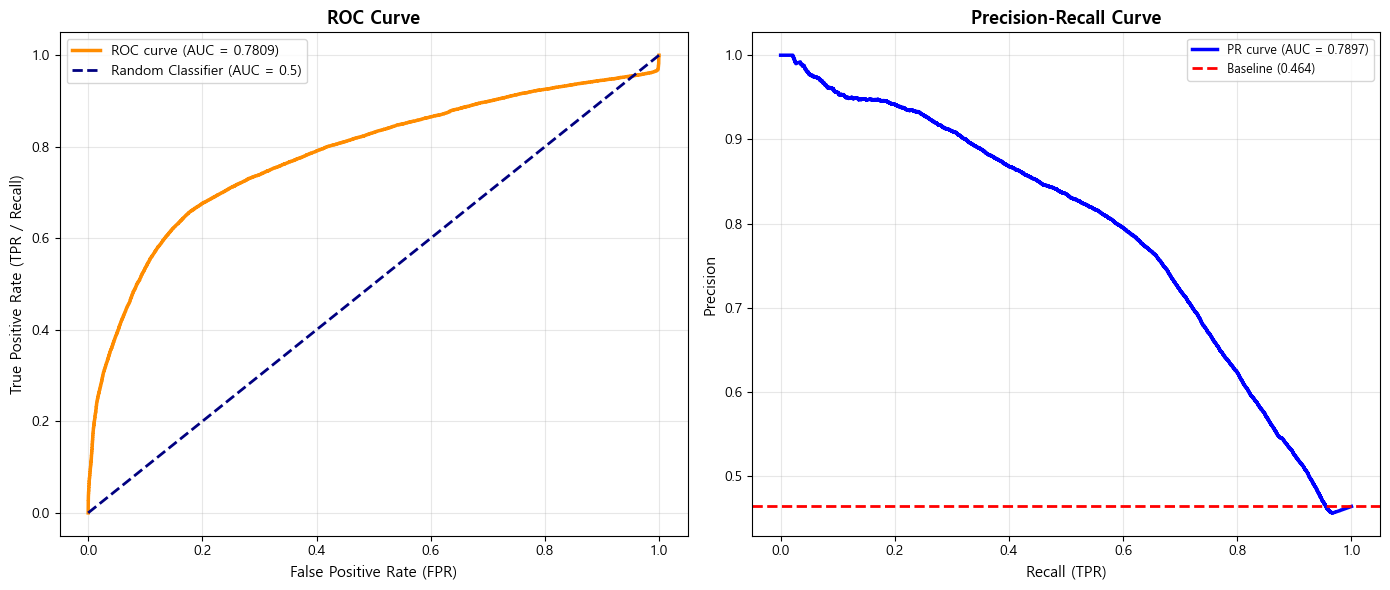


📌 곡선 해석 가이드:
   • ROC 곡선의 'Random': 완전히 랜덤한 예측 (AUC=0.5)
     → 모델이 이보다 나쁘면 사용 가치 없음
   • PR 곡선의 'Baseline': 모든 샘플을 비정상으로 예측할 때의 Precision
     → 모델이 이보다 나쁘면 단순히 '모두 비정상' 예측과 동일


In [ ]:
# ============================================
# ROC 및 PR 곡선 시각화
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ============================================
# ROC 곡선 (Receiver Operating Characteristic Curve)
# ============================================
axes[0].plot(fpr, tpr, color='darkorange', lw=2.5, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random Classifier (AUC = 0.5)')
axes[0].set_xlabel('False Positive Rate (FPR)', fontsize=11)
axes[0].set_ylabel('True Positive Rate (TPR / Recall)', fontsize=11)
axes[0].set_title('ROC Curve', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)





# ============================================
# Precision-Recall 곡선
# ============================================
baseline_precision = len(anomaly_errors) / len(all_labels)
axes[1].plot(recall, precision, color='blue', lw=2.5, 
             label=f'PR curve (AUC = {pr_auc:.4f})')
axes[1].axhline(y=baseline_precision, color='r', linestyle='--', linewidth=2,
                label=f'Baseline ({baseline_precision:.3f})')
axes[1].set_xlabel('Recall (TPR)', fontsize=11)
axes[1].set_ylabel('Precision', fontsize=11)
axes[1].set_title('Precision-Recall Curve', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)


axes[1].legend(fontsize=9)




plt.tight_layout()
plt.show()

print("\n📌 곡선 해석 가이드:")
print("   • ROC 곡선의 'Random': 완전히 랜덤한 예측 (AUC=0.5)")
print("     → 모델이 이보다 나쁘면 사용 가치 없음")
print("   • PR 곡선의 'Baseline': 모든 샘플을 비정상으로 예측할 때의 Precision")
print("     → 모델이 이보다 나쁘면 단순히 '모두 비정상' 예측과 동일")


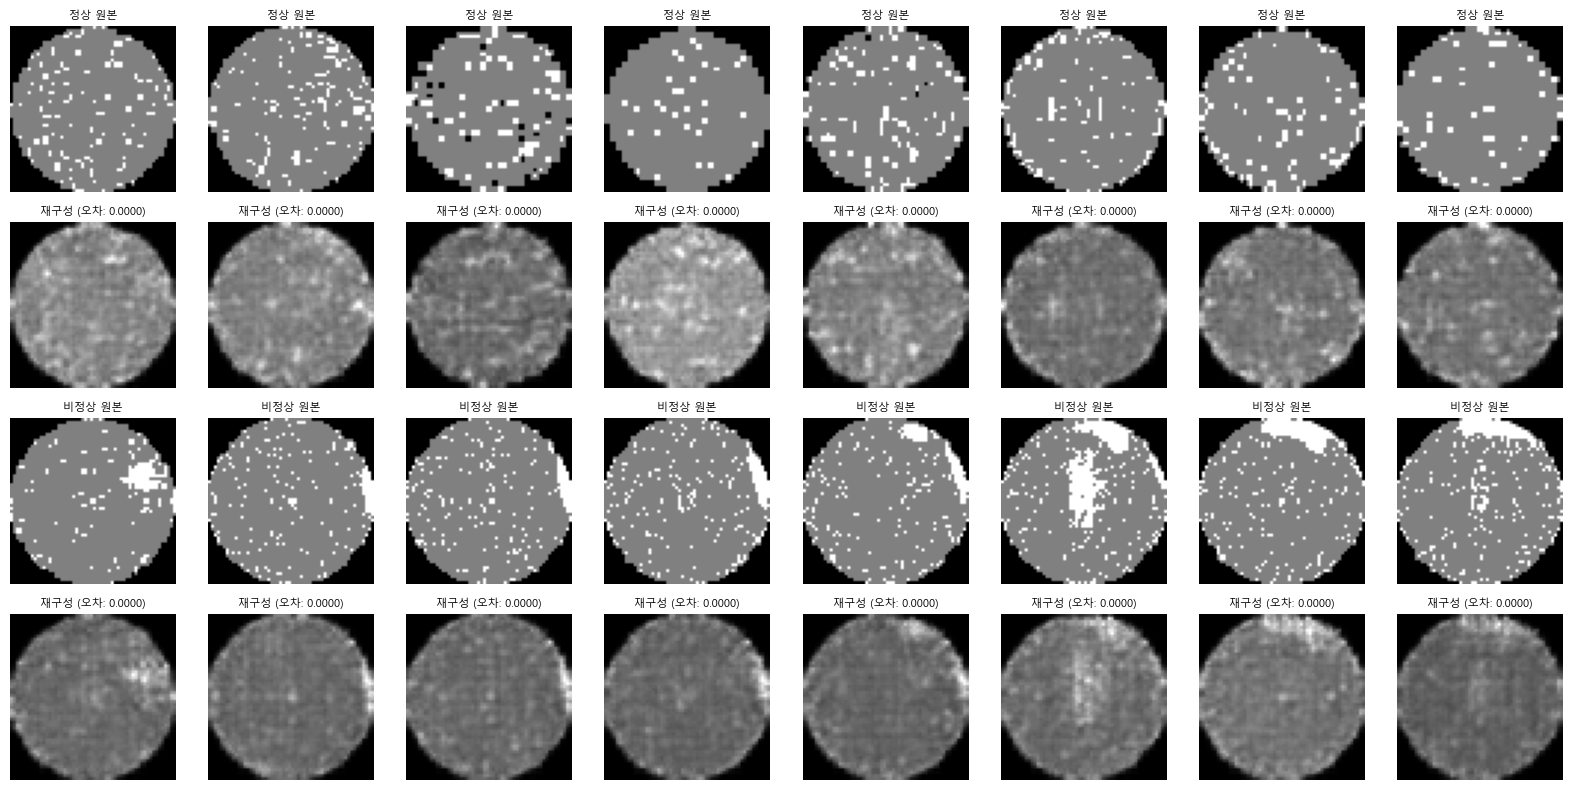

In [110]:
# 재구성 오차 분포 시각화
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

font_path = "C:/Windows/Fonts/malgun.ttf"  # '맑은 고딕' 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

ae_model.eval()
with torch.no_grad():
    # 정상 데이터 샘플
    normal_xb, _ = next(iter(normal_val_loader))
    normal_xb = normal_xb[:8].to(device)
    normal_recon = ae_model(normal_xb)
    
    # 비정상 데이터 샘플
    anomaly_xb, _ = next(iter(anomaly_loader))
    anomaly_xb = anomaly_xb[:8].to(device)
    anomaly_recon = ae_model(anomaly_xb)

# 시각화
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

# 정상 데이터 원본
for i in range(8):
    img = normal_xb[i].cpu().squeeze().numpy()
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title('정상 원본', fontsize=8)
    axes[0, i].axis('off')

# 정상 데이터 재구성
for i in range(8):
    img = normal_recon[i].cpu().squeeze().numpy()
    error = ((normal_xb[i] - normal_recon[i]) ** 2).mean().item()
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title(f'재구성 (오차: {error:.4f})', fontsize=8)
    axes[1, i].axis('off')

# 비정상 데이터 원본
for i in range(8):
    img = anomaly_xb[i].cpu().squeeze().numpy()
    axes[2, i].imshow(img, cmap='gray')
    axes[2, i].set_title('비정상 원본', fontsize=8)
    axes[2, i].axis('off')

# 비정상 데이터 재구성
for i in range(8):
    img = anomaly_recon[i].cpu().squeeze().numpy()
    error = ((anomaly_xb[i] - anomaly_recon[i]) ** 2).mean().item()
    axes[3, i].imshow(img, cmap='gray')
    axes[3, i].set_title(f'재구성 (오차: {error:.4f})', fontsize=8)
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()
